### STATS 507 Final Project: Sentiment Analysis of Customer Satisfaction Across 48 U.S. Banks
##### Name: Ruoyi Li
##### GitHub Repo: https://github.com/Ophelia1107/Stats-507-Winter-2025_Coursework.git

In [197]:
# Dataset Setup section:
from datasets import load_dataset
import pandas as pd

# Load the full dataset from Hugging Face
dataset = load_dataset("TrainingDataPro/customers-reviews-on-banks")

# Extract the targeted variables from the 'train' split
df = dataset['train'].to_pandas()[['bank', 'star', 'text']]

In [198]:
from tabulate import tabulate

# Categorize star ratings
def categorize_rating(star):
    if star in [1, 2]:
        return 'poor'
    elif star == 3:
        return 'neutral'
    elif star in [4, 5]:
        return 'good'
    else:
        return 'unknown'

# Apply categorization
df['rating_category'] = df['star'].apply(categorize_rating)

# Group and summarize
bank_summary = df.groupby('bank').agg(
    avg_star=('star', 'mean'),
    count=('star', 'count'),
    poor_reviews=('rating_category', lambda x: (x == 'poor').sum()),
    neutral_reviews=('rating_category', lambda x: (x == 'neutral').sum()),
    good_reviews=('rating_category', lambda x: (x == 'good').sum()),
)

In [199]:
# Add good_ratio column (same as positive_ratio in LSTM logic)
bank_summary["positive_ratio"] = bank_summary["good_reviews"] / bank_summary["count"]

# Get top 5 banks based on good_ratio
top_5_banks = bank_summary.sort_values(by='positive_ratio', ascending=False).head(5)

# Print the result as a table
print("Top 5 Banks Based on Good Review Ratio (Star Rating-Based):")
print(tabulate(top_5_banks.reset_index(), headers="keys", tablefmt="fancy_grid"))


Top 5 Banks Based on Good Review Ratio (Star Rating-Based):
╒════╤═════════════════════════════════╤════════════╤═════════╤════════════════╤═══════════════════╤════════════════╤══════════════════╕
│    │ bank                            │   avg_star │   count │   poor_reviews │   neutral_reviews │   good_reviews │   positive_ratio │
╞════╪═════════════════════════════════╪════════════╪═════════╪════════════════╪═══════════════════╪════════════════╪══════════════════╡
│  0 │ bmo-harris-bank                 │    5       │       2 │              0 │                 0 │              2 │         1        │
├────┼─────────────────────────────────┼────────────┼─────────┼────────────────┼───────────────────┼────────────────┼──────────────────┤
│  1 │ merrick_bank                    │    3.60948 │    1160 │            364 │                69 │            727 │         0.626724 │
├────┼─────────────────────────────────┼────────────┼─────────┼────────────────┼───────────────────┼────────────────┼─

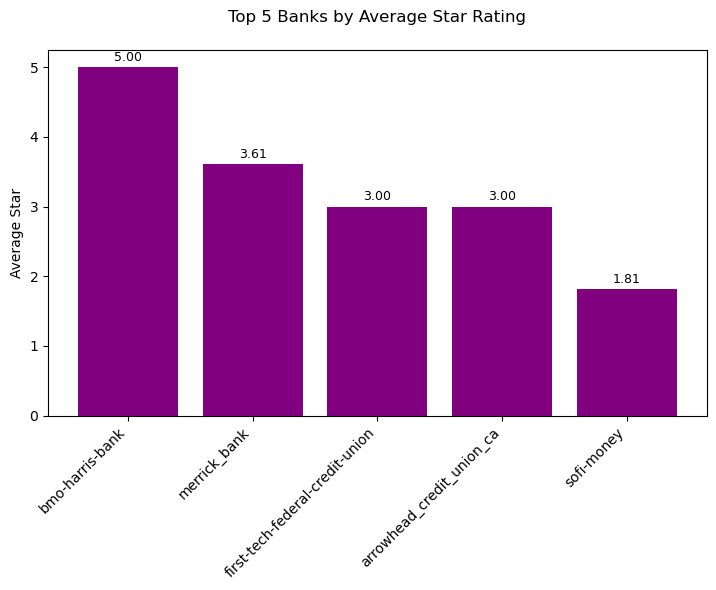

In [203]:
import matplotlib.pyplot as plt

# Plotting the histogram for the top 5 banks
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(top_5_banks.index, top_5_banks['avg_star'], color='purple')
plt.title("Top 5 Banks by Average Star Rating", pad=20)
plt.ylabel("Average Star")
plt.xticks(rotation=45, ha='right')

# Add labels on the top of each bar to better identity indivdual avg stars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,  
        f"{height:.2f}", 
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'  
    )

plt.tight_layout()
plt.show()


In [233]:
from tabulate import tabulate

# Truncate long bank names to 30 characters for cleaner display
def truncate_name(name, max_len=30):
    return name if len(name) <= max_len else name[:max_len-3] + "..."

# Apply name truncation before printing
bottom_5_banks = bottom_5_banks.reset_index()
bottom_5_banks["bank"] = bottom_5_banks["bank"].apply(truncate_name)

# Display the cleaned table
print("Worst 5 Banks Based on Negative Review Ratio (Star Rating–Based):\n")
print(tabulate(bottom_5_banks, headers="keys", tablefmt="fancy_grid"))


Bottom 5 Banks Based on Negative Review Ratio (Star Rating–Based):

╒════╤════════════════════════════════╤════════════╤═════════╤════════════════╤═══════════════════╤════════════════╤══════════════════╕
│    │ bank                           │   avg_star │   count │   poor_reviews │   neutral_reviews │   good_reviews │   positive_ratio │
╞════╪════════════════════════════════╪════════════╪═════════╪════════════════╪═══════════════════╪════════════════╪══════════════════╡
│  0 │ liberty-federal-credit-union   │    1       │       1 │              1 │                 0 │              0 │         1        │
├────┼────────────────────────────────┼────────────┼─────────┼────────────────┼───────────────────┼────────────────┼──────────────────┤
│  1 │ bofa_gift_card                 │    1       │       4 │              4 │                 0 │              0 │         1        │
├────┼────────────────────────────────┼────────────┼─────────┼────────────────┼───────────────────┼────────────────┼

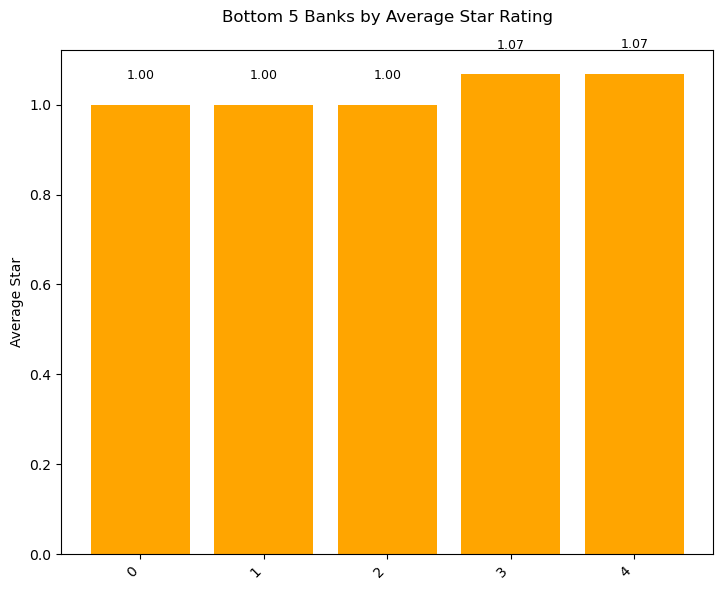

In [235]:
# Plotting the histogram for the bottom 5 banks
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
bars = plt.bar(bottom_5_banks.index, bottom_5_banks['avg_star'], color='orange')
plt.title("Worst 5 Banks by Average Star Rating", pad=20)
plt.ylabel("Average Star")
plt.xticks(rotation=45, ha='right')

# Add labels on the top of each bar to better identity indivdual avg stars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [209]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [211]:
# Assume df is already defined
df = df[df["text"].notna() & df["star"].notna()]
# Map star to sentiment labels
def map_star_to_sentiment(star):
    if star <= 2:
        return 0  # negative
    elif star == 3:
        return 1  # neutral
    else:
        return 2  # positive

df["label"] = df["star"].apply(map_star_to_sentiment)

In [80]:
# Basic tokenizer
def tokenize(text):
    return re.sub(r"[^\w\s]", "", text.lower()).split()

In [82]:
# Build vocabulary
all_tokens = [token for text in df["text"] for token in tokenize(text)]
token_counts = Counter(all_tokens)
vocab = {token: i+2 for i, (token, _) in enumerate(token_counts.items())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

In [84]:
def text_to_seq(text, max_len=100):
    tokens = tokenize(text)
    ids = [vocab.get(t, 1) for t in tokens][:max_len]
    ids += [0] * (max_len - len(ids))
    return ids

In [86]:
# Custom Dataset
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, max_len=100):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        x = torch.tensor(text_to_seq(self.texts[idx], self.max_len))
        y = torch.tensor(self.labels[idx])
        return x, y

In [88]:
# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_dataset = ReviewDataset(train_df["text"].tolist(), train_df["label"].tolist())
test_dataset = ReviewDataset(test_df["text"].tolist(), test_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [90]:
# LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, output_dim=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [107]:
# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 0.0027
Epoch 2: Loss = 0.0020
Epoch 3: Loss = 0.0015
Epoch 4: Loss = 0.0011
Epoch 5: Loss = 0.0008
Epoch 6: Loss = 0.0006
Epoch 7: Loss = 0.0005
Epoch 8: Loss = 0.0004
Epoch 9: Loss = 0.0003
Epoch 10: Loss = 0.0002
Epoch 11: Loss = 0.0002
Epoch 12: Loss = 0.0001
Epoch 13: Loss = 0.0001
Epoch 14: Loss = 0.0001
Epoch 15: Loss = 0.0001
Epoch 16: Loss = 0.0000
Epoch 17: Loss = 0.0000
Epoch 18: Loss = 0.0000
Epoch 19: Loss = 0.0000
Epoch 20: Loss = 0.0000
Epoch 21: Loss = 0.0000
Epoch 22: Loss = 0.0000
Epoch 23: Loss = 0.0000
Epoch 24: Loss = 0.0000
Epoch 25: Loss = 0.0000
Epoch 26: Loss = 0.0000
Epoch 27: Loss = 0.0000
Epoch 28: Loss = 0.0000
Epoch 29: Loss = 0.0000
Epoch 30: Loss = 0.0000
Epoch 31: Loss = 0.0000
Epoch 32: Loss = 0.0000
Epoch 33: Loss = 0.0000
Epoch 34: Loss = 0.0000
Epoch 35: Loss = 0.0000
Epoch 36: Loss = 0.0000


KeyboardInterrupt: 

In [109]:
# Predict function (text-only)
def predict_sentiment(texts, max_len=100):
    model.eval()
    results = []
    with torch.no_grad():
        for text in texts:
            seq = torch.tensor(text_to_seq(text, max_len)).unsqueeze(0).to(device)
            pred = model(seq)
            label = torch.argmax(pred, dim=1).item()
            results.append(label)
    return results

In [111]:
# Predict sentiment on all reviews
df["predicted_sentiment"] = predict_sentiment(df["text"].tolist())

In [145]:
from tabulate import tabulate

# Calculate positive ratio (already in your summary, but just in case)
summary["positive_ratio"] = summary["positive"] / summary["total"]

# Sort by highest positive_ratio and take top 5
top_5 = summary.sort_values("positive_ratio", ascending=False).head(5).reset_index()

# Display as table
print("Top 5 Banks by Positive Sentiment Ratio:")
print(tabulate(top_5[["bank", "positive", "neutral", "negative", "positive_ratio"]],
               headers="keys", tablefmt="fancy_grid"))


Top 5 Banks by Positive Sentiment Ratio:
╒════╤═════════════════════════════════╤════════════╤═══════════╤════════════╤══════════════════╕
│    │ bank                            │   positive │   neutral │   negative │   positive_ratio │
╞════╪═════════════════════════════════╪════════════╪═══════════╪════════════╪══════════════════╡
│  0 │ bmo-harris-bank                 │          2 │         0 │          0 │         1        │
├────┼─────────────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  1 │ merrick_bank                    │        720 │        58 │        381 │         0.621225 │
├────┼─────────────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  2 │ first-tech-federal-credit-union │          1 │         0 │          1 │         0.5      │
├────┼─────────────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  3 │ arrowhead_credit_union_ca       │          4 │         0 │          6 

In [147]:
# Calculate negative ratio
summary["negative_ratio"] = summary["negative"] / summary["total"]

# Sort by highest negative_ratio and take bottom 5
worst_5 = summary.sort_values("negative_ratio", ascending=False).head(5).reset_index()

# Display as table
print("Worst 5 Banks by Negative Sentiment Ratio:")
print(tabulate(worst_5[["bank", "negative", "neutral", "positive", "negative_ratio"]],
               headers="keys", tablefmt="fancy_grid"))


Worst 5 Banks by Negative Sentiment Ratio:
╒════╤═══════════════════════════════════════╤════════════╤═══════════╤════════════╤══════════════════╕
│    │ bank                                  │   negative │   neutral │   positive │   negative_ratio │
╞════╪═══════════════════════════════════════╪════════════╪═══════════╪════════════╪══════════════════╡
│  0 │ cit-bank                              │          2 │         0 │          0 │         1        │
├────┼───────────────────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  1 │ liberty-federal-credit-union          │          1 │         0 │          0 │         1        │
├────┼───────────────────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  2 │ bofa_gift_card                        │          4 │         0 │          0 │         1        │
├────┼───────────────────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  3 │ world-financia